In [2]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import matplotlib.cm as cm
from sklearn.metrics import confusion_matrix
from IPython.display import display
from pathlib import Path
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)
plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
%matplotlib inline

In [1]:
df_initial = pd.read_csv('data/data.csv',encoding="ISO-8859-1",dtype={'CustomerID': str,'InvoiceID': str},parse_dates = ['InvoiceDate'])
df_initial.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom


In [3]:
v1=df_initial.shape[0]
df_initial.shape

(541909, 8)

In [5]:
df_initial=df_initial.rename(columns={"InvoiceNo": "invoice_no", "StockCode": "stock_code", "Description": "desc","Quantity":"quan","InvoiceDate":"invoice_date","UnitPrice":"unit_price","CustomerID":"customer_id","Country":"country"})


In [6]:
# droping rows with no Customer ID
df_initial.dropna(axis = 0, subset = ['customer_id'], inplace = True)
df_initial.shape
v2= df_initial.shape[0]
df_initial.shape

(406829, 8)

In [7]:
print("number of rows without customer_id {}".format(v1-v2))

number of rows without customer_id 135080


In [8]:
country_count_df = df_initial[['customer_id', 'invoice_no', 'country']].groupby(['customer_id', 'invoice_no', 'country']).count()
country_count_df = country_count_df.reset_index(drop = False)
country_count_df = country_count_df['country'].value_counts()
print('No of countries: {}'.format(len(country_count_df)))

No of countries: 37


In [9]:
country_count_df = country_count_df.reset_index(drop = False)

In [10]:
country_count_df = country_count_df.rename(columns={'index':'country','country':'count'})
country_count_df

,country,count
0,United Kingdom,19857
1,Germany,603
2,France,458
3,EIRE,319
4,Belgium,119
5,Spain,105
6,Netherlands,101
7,Switzerland,71
8,Portugal,70
9,Australia,69


In [11]:
# generate country code  based on country name 
import pycountry 
def alpha3code(column):
    CODE=[]
    for country in column:
        try:
            code=pycountry.countries.get(name=country).alpha_3
            CODE.append(code)
        except:
            CODE.append('None')
    return CODE

# create a column for 3 alpha code 
country_count_df['CODE']=alpha3code(country_count_df.country)
country_count_df.head()

# Merging with our country count data frame
location=pd.read_csv('https://raw.githubusercontent.com/melanieshi0120/COVID-19_global_time_series_panel_data/master/data/countries_latitude_longitude.csv')
country_distribution_coordinates=country_count_df.merge(location,left_on='country',right_on='name').sort_values(by='count',ascending=False).reset_index()
country_distribution_coordinates = country_distribution_coordinates[['country','count','latitude','longitude','CODE']]
country_distribution_coordinates

,country,count,latitude,longitude,CODE
0,United Kingdom,19857,55.378051,-3.435973,GBR
1,Germany,603,51.165691,10.451526,DEU
2,Belgium,119,50.503887,4.469936,BEL
3,Spain,105,40.463667,-3.749220,ESP
4,Netherlands,101,52.132633,5.291266,NLD
5,Switzerland,71,46.818188,8.227512,CHE
6,Portugal,70,39.399872,-8.224454,PRT
7,Australia,69,-25.274398,133.775136,AUS
8,Italy,55,41.871940,12.567380,ITA
9,Finland,48,61.892635,-6.911806,FIN


In [12]:
world_map = df_initial[['customer_id', 'invoice_no', 'country']].groupby(['customer_id', 'invoice_no', 'country']).count().reset_index(drop = False)
countries = world_map['country'].value_counts()
data = dict(z = countries,text = countries.index,colorbar = {'title':'Orders'},colorscale='tropic',reversescale = False,type='choropleth',locations = countries.index,locationmode = 'country names')
layout = dict(title={'xanchor': 'center','yanchor': 'top','text': "Number of Orders by Countries",'y':0.9,'x':0.5},geo = dict(landcolor = "LightYellow",showframe = True,resolution = 50,showocean = True,oceancolor = "LightBlue",showland = True),template = 'ggplot2',height = 600,width = 1000)
choromap = go.Figure(data = [data], layout = layout)
iplot(choromap, validate = True)

In [13]:
df_initial

,invoice_no,stock_code,desc,quan,invoice_date,unit_price,customer_id,country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...
541904,581587,22613,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


In [14]:
print('Unique Customer :{} , Unique Products :{} , Unique Transactions :{}'.format(len(df_initial['customer_id'].value_counts()),len(df_initial['stock_code'].value_counts()),len(df_initial['invoice_no'].value_counts())))

Unique Customer :4372 , Unique Products :3684 , Unique Transactions :22190


In [15]:
temporary = df_initial.groupby(by=['customer_id', 'invoice_no'], as_index=False)['invoice_date'].count()
items_in_order = temporary.rename(columns = {'invoice_date':'number_of_products_in_transaction'})
items_in_order[:5].sort_values('customer_id')

,customer_id,invoice_no,number_of_products_in_transaction
0,12346,541431,1
1,12346,C541433,1
2,12347,537626,31
3,12347,542237,29
4,12347,549222,24


In [16]:
items_in_order['order_canceled'] = items_in_order['invoice_no'].apply(lambda x:int('C' in x))
display(items_in_order[:5])
n1 = items_in_order['order_canceled'].sum()
n2 = items_in_order.shape[0]
# Analysis on Cancalled Orders
print('Number of orders canceled: {} out of {}'.format(n1, n2))
print('Percentage of orders canceled: {:.2f}%'.format(n1/n2*100))

,customer_id,invoice_no,number_of_products_in_transaction,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


Number of orders canceled: 3654 out of 22190
Percentage of orders canceled: 16.47%


In [17]:
df_dates = df_initial

In [18]:
df_dates.insert( value=df_dates['invoice_date'].map(lambda x: 100*x.year + x.month),loc=2, column='year_month')
df_dates.insert( value=df_dates.invoice_date.dt.month,loc=3, column='month')
df_dates.insert( value=(df_dates.invoice_date.dt.dayofweek)+1,loc=4, column='day')
df_dates.insert(value=df_dates.invoice_date.dt.hour,loc=5, column='hour')

In [19]:
df_dates

,invoice_no,stock_code,year_month,month,day,hour,desc,quan,invoice_date,unit_price,customer_id,country
0,536365,85123A,201012,12,3,8,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom
1,536365,71053,201012,12,3,8,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
2,536365,84406B,201012,12,3,8,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom
3,536365,84029G,201012,12,3,8,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
4,536365,84029E,201012,12,3,8,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom
...,...,...,...,...,...,...,...,...,...,...,...,...
541904,581587,22613,201112,12,5,12,PACK OF 20 SPACEBOY NAPKINS,12,2011-12-09 12:50:00,0.85,12680,France
541905,581587,22899,201112,12,5,12,CHILDREN'S APRON DOLLY GIRL,6,2011-12-09 12:50:00,2.10,12680,France
541906,581587,23254,201112,12,5,12,CHILDRENS CUTLERY DOLLY GIRL,4,2011-12-09 12:50:00,4.15,12680,France
541907,581587,23255,201112,12,5,12,CHILDRENS CUTLERY CIRCUS PARADE,4,2011-12-09 12:50:00,4.15,12680,France


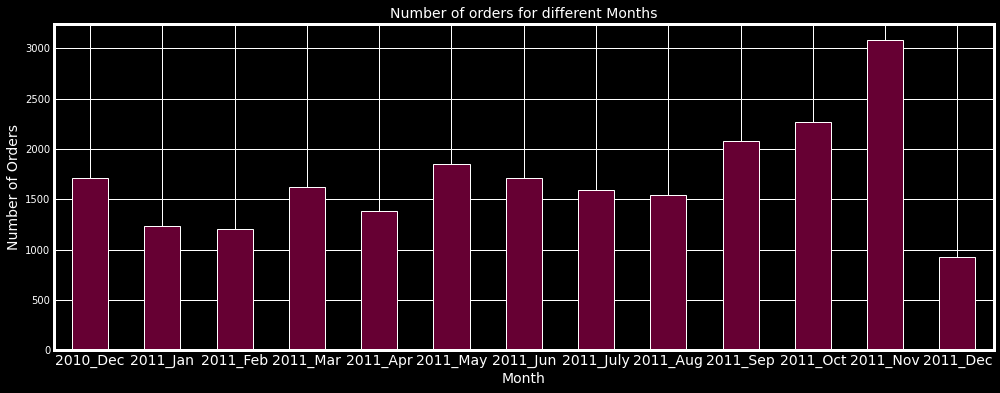

In [20]:
plt.style.use('dark_background')
ax = df_dates.groupby('invoice_no')['year_month'].unique().value_counts().sort_index().plot(color='#660033',kind='bar',figsize=(15,6))
ax.set_xlabel('Month',fontsize=14)
ax.set_ylabel('Number of Orders',fontsize=14)
ax.set_title('Number of orders for different Months',fontsize=14)
ax.set_xticklabels(('2010_Dec','2011_Jan','2011_Feb','2011_Mar','2011_Apr','2011_May','2011_Jun','2011_July','2011_Aug','2011_Sep','2011_Oct','2011_Nov','2011_Dec'), rotation='horizontal', fontsize=14)
plt.show()

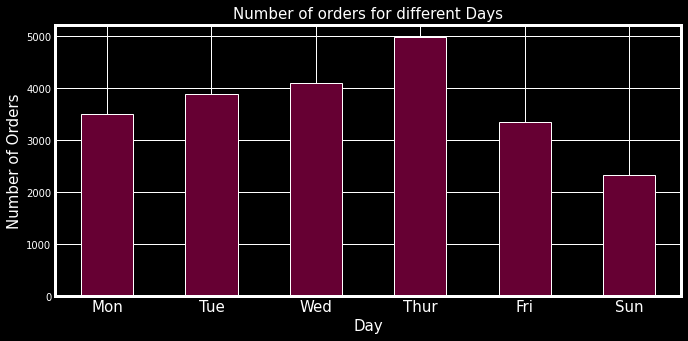

In [21]:
plt.style.use('dark_background')
ax = df_dates.groupby('invoice_no')['day'].unique().value_counts().sort_index().plot(color='#660033',kind='bar',figsize=(10,5))
ax.set_xlabel('Day',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Days',fontsize=15)
ax.set_xticklabels(('Mon','Tue','Wed','Thur','Fri','Sun'), rotation='horizontal', fontsize=15)
plt.show()

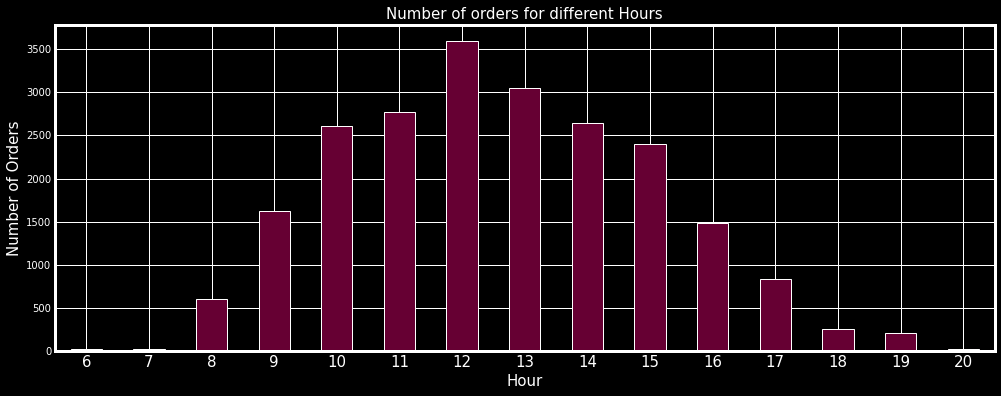

In [22]:
plt.style.use('dark_background')
ax = df_dates.groupby('invoice_no')['hour'].unique().value_counts().iloc[:-1].sort_index().plot(kind='bar',color="#660033",figsize=(15,6))
ax.set_xlabel('Hour',fontsize=15)
ax.set_ylabel('Number of Orders',fontsize=15)
ax.set_title('Number of orders for different Hours',fontsize=15)
ax.set_xticklabels(range(6,21), rotation='horizontal', fontsize=15)
plt.show()

# RFM

In [23]:
items_in_order['order_canceled'] = items_in_order['invoice_no'].apply(lambda x:int('C' in x))
display(items_in_order[:5])
n1 = items_in_order['order_canceled'].sum()
n2 = items_in_order.shape[0]


,customer_id,invoice_no,number_of_products_in_transaction,order_canceled
0,12346,541431,1,0
1,12346,C541433,1,1
2,12347,537626,31,0
3,12347,542237,29,0
4,12347,549222,24,0


In [24]:
df_initial['total_price'] = df_initial["quan"] * df_initial["unit_price"]

In [ ]:
print("Min date: {} \nMax date: {}".format(df_initial.invoice_date.min(), df_initial.invoice_date.max()))

In [25]:
last_day = df_initial.invoice_date.max() + dt.timedelta(days = 1)
cs_df = df_initial.groupby("customer_id").agg({"invoice_date": lambda x: (last_day - x.max()).days,"invoice_no": "nunique","total_price": "sum"})
cs_df.rename(columns = {"invoice_date": "rec","invoice_no": "freq","total_price": "mon"}, inplace = True)


In [26]:
cs_df.head()

,rec,freq,mon
customer_id,,,
12346,326,2,0.00
12347,2,7,4310.00
12348,75,4,1797.24
12349,19,1,1757.55
12350,310,1,334.40


In [27]:
r = range(5,0,-1)
f = range(1,6,1)
m = range(1,6,1)

In [28]:
cs_df["r"] = pd.qcut(cs_df["rec"], 5, labels = r)
cs_df["f"] = pd.qcut(cs_df["freq"].rank(method = 'first'), 5, labels = f)
cs_df["m"] = pd.qcut(cs_df["mon"], 5, labels = m)

In [30]:
cs_df["rfm"] = cs_df["r"].astype(str) + cs_df["f"].astype(str) + cs_df["m"].astype(str)
cs_df["score_rfm"] = cs_df[["r", "f", "m"]].sum(axis = 1)

In [32]:
seg_map = {r'[1-2][1-2]': 'Hibernating',r'[1-2][3-4]': 'At-Risk',r'[1-2]5': 'Cannot lose them',r'3[1-2]': 'About To Sleep',r'33': 'Need Attention',r'[3-4][4-5]': 'Loyal Customers',r'41': 'Promising',r'51': 'New Customers',r'[4-5][2-3]': 'Potential Loyalists',r'5[4-5]': 'Champions'}
cs_df['Segment'] = cs_df['r'].astype(str) + cs_df['f'].astype(str)
cs_df['Segment'] = cs_df['Segment'].replace(seg_map, regex=True)

In [33]:
cs_df.head()

,rec,freq,mon,r,f,m,rfm,score_rfm,Segment
customer_id,,,,,,,,,
12346,326,2,0.00,1,2,1,121,4,Hibernating
12347,2,7,4310.00,5,4,5,545,14,Champions
12348,75,4,1797.24,2,3,4,234,9,At-Risk
12349,19,1,1757.55,4,1,4,414,9,Promising
12350,310,1,334.40,1,1,2,112,4,Hibernating


In [36]:
rfm_coords = {"Champions": [3, 5, 0.8, 1],
                   "Loyal Customers": [0, 1, 0.6, 0.8],
                   "Cannot lose them": [4, 5, 0, 0.4],
                   "At-Risk": [2, 4, 0, 0.4],
                   "Hibernating": [0, 2, 0, 0.4],
                   "Promising": [3, 5, 0.4, 0.8] ,
                   "New Customers": [0, 1, 0.8, 1],
                   "About To Sleep": [0, 2, 0.4, 0.6],
                   "Potential Loyalists": [1, 3, 0.6, 1],
                   "Need Attention": [2, 3, 0.4, 0.6]}

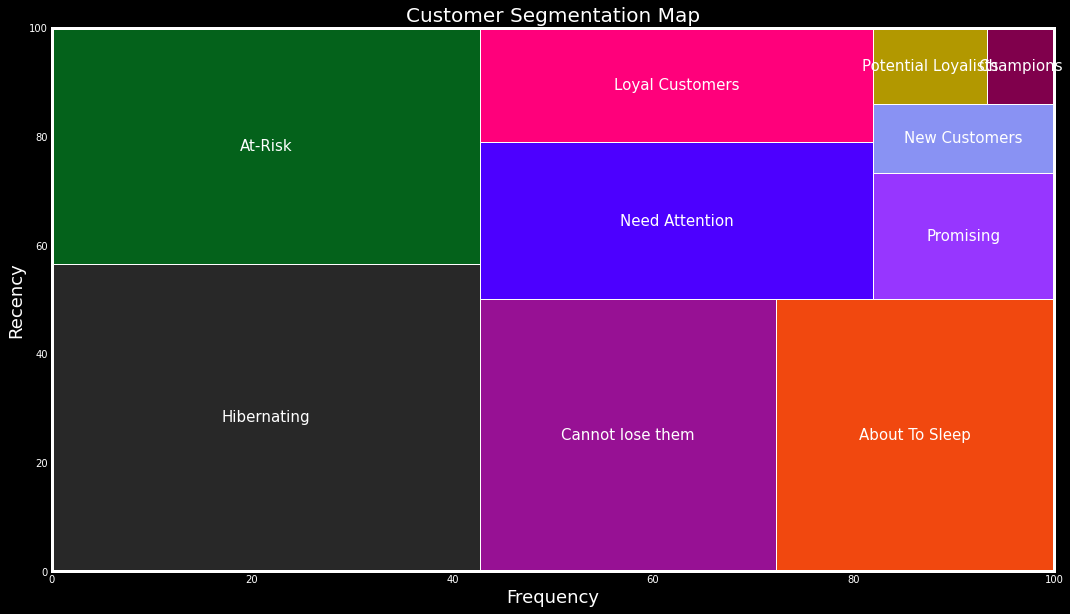

In [37]:
import squarify
segments = cs_df['Segment'].value_counts().sort_values(ascending = False)
fig = plt.gcf()
ax = fig.add_subplot()
fig.set_size_inches(16, 10)
squarify.plot(sizes=segments,
              label=[label for label in seg_map.values()],
              color=["#282828", "#04621B", "#971194", "#F1480F",  "#4C00FF", "#FF007B", "#9736FF", "#8992F3", "#B29800", "#80004C"],
              pad = False,
              bar_kwargs = {'alpha': 1},
              text_kwargs = {'fontsize':15})
plt.title("Customer Segmentation Map", fontsize = 20)
plt.xlabel('Frequency', fontsize = 18)
plt.ylabel('Recency', fontsize = 18)
plt.show()

In [38]:
cs_df_vis = cs_df.reset_index()
cs_df_size = cs_df_vis.groupby("Segment").agg({"mon": "mean","customer_id": "nunique"})
cs_df_size.rename(columns = {"mon": "mon_mean", "customer_id": "number_of_customers"}, inplace = True)
cs_df_size = cs_df_size.sort_values("mon_mean", ascending = False)

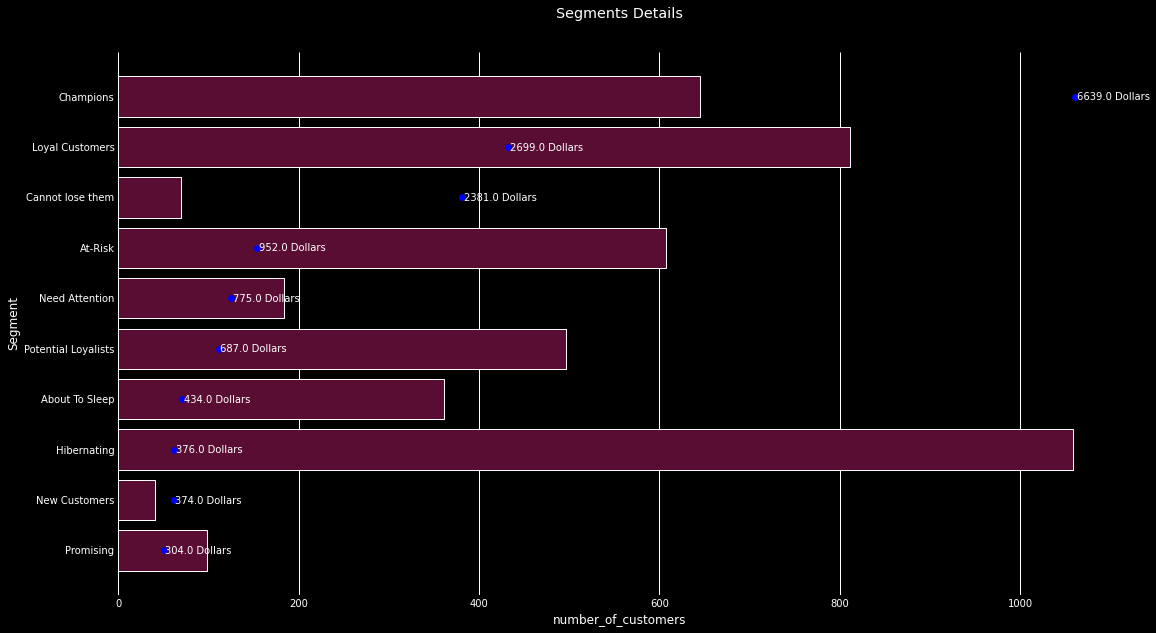

In [39]:
plt.style.use('dark_background')
fig, ax = plt.subplots(figsize = (16, 10))
sns.barplot(x = cs_df_size.number_of_customers, y = cs_df_size.index, ax = ax, color = "#660033")
ax2 = ax.twiny()
sns.lineplot(x = cs_df_size.mon_mean , y = cs_df_size.index, ax = ax2, marker = "o", linewidth = 0,
             color = "b", markeredgecolor = "b")
ax2.axis("off")
for y, x in list(enumerate(round(cs_df_size.mon_mean,0))):
    ax2.text(x + 12, y + 0.07, str(x) + " Dollars", fontweight = "normal")
plt.title("Segments Details")
sns.despine(left = True, right = True, bottom = True, top = True)
plt.show()

Different client segments and their average spending are shown in the above Figure. The hibernating group is the biggest consumer category, and they spend $376 on an average which is 10 to 20 times less than the next biggest categories, which are loyal customers and champions. E-commerce businesses should ideally focus their marketing efforts on these segments.

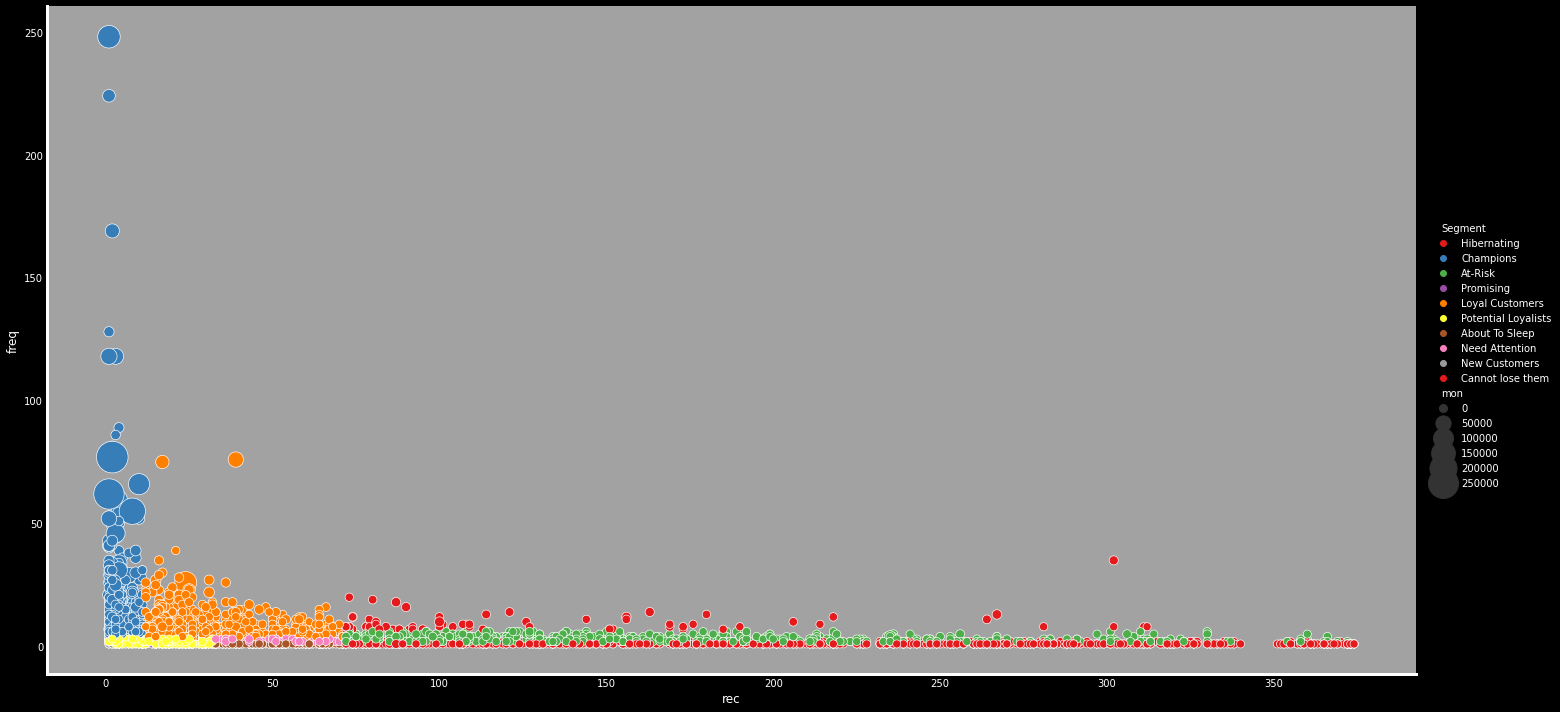

In [41]:
plt.style.use('dark_background')
plt.rcParams["axes.facecolor"] = "#A2A2A2"
plt.rcParams["axes.grid"] = False
sns.relplot(x = "rec", y = "freq", hue = "Segment", size = "mon", data = cs_df_vis, palette = 'Set1',height = 10, aspect = 2, sizes = (50, 1000))
plt.show()

In [91]:
rfm_clustering = cs_df[["r", "f", "m", "Segment"]]

for col in ["r", "f", "m"]:
    
    scaler = StandardScaler()
    rfm_clustering[col] = np.log(rfm_clustering[col])
    rfm_clustering[col] = scaler.fit_transform(rfm_clustering[col].values.reshape(-1, 1))
    
rfm_melted = pd.melt(rfm_clustering, id_vars = "Segment", value_vars = ["r", "f", "m"],
                     var_name = "RFM", value_name = "Value")

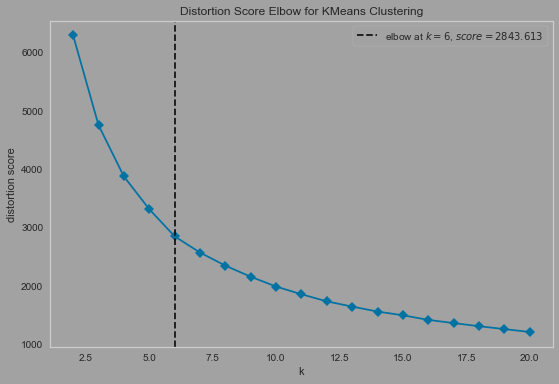

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [93]:
from yellowbrick.cluster import KElbowVisualizer
kmeans_ = KMeans(init = "k-means++", random_state = 42)
fig, ax = plt.subplots(figsize = (9, 6), facecolor = "#A2A2A2")
ax.set_facecolor("#A2A2A2")
ax.grid(False)
visualizer = KElbowVisualizer(kmeans_, k = (2, 21), timings = False)
visualizer.fit(rfm_clustering[['r','f','m']]) 
visualizer.show()

In [ ]:
rfm_clustering = rfm_clustering.rename(columns={"r": "Recency","f":"Frequency","m":"Monetary"})

In [98]:
rfm_clustering

,Recency,Frequency,Monetary,Segment
0,-2.149991,1.129100,1.436567,Champions
1,0.383006,0.504604,0.601759,At-Risk
2,-0.576597,-1.042412,0.590699,Promising
3,1.374783,-1.042412,-0.672723,Hibernating
4,-0.129954,1.129100,0.572428,Loyal Customers
...,...,...,...,...
4293,1.298638,-1.042412,-1.065512,Hibernating
4294,0.998730,-1.042412,-1.711828,Hibernating
4295,-1.181131,-0.268904,-1.076942,Potential Loyalists
4296,-1.665561,2.051620,0.902328,Champions


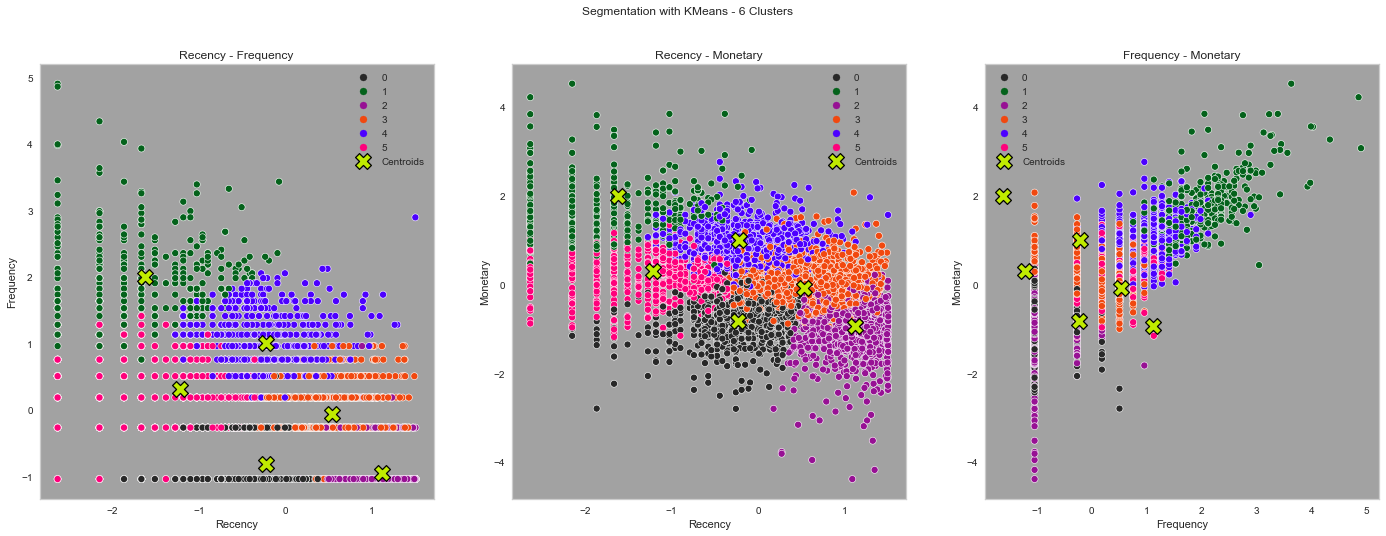

In [94]:
from itertools import combinations
kmeans = KMeans(n_clusters = 6, random_state = 23) 
kmeans.fit(rfm_clustering[["Recency", "Frequency", "Monetary"]])
cluster = kmeans.labels_

fig, axes = plt.subplots(1, 3, figsize = (24, 8))

for i, feature in list(enumerate(combinations(["Recency", "Frequency", "Monetary"], 2))):

    sns.scatterplot(x = rfm_clustering[feature[0]], y = rfm_clustering[feature[1]], hue = cluster, 
                    palette = 'Set2'[: len(set(cluster))], ax = axes[i]).set_title(feature[0] + " - " + feature[1])

    sns.scatterplot(x = kmeans.cluster_centers_[:, 0], y = kmeans.cluster_centers_[:, 1],
                    s = 250, color = '#C0EB00', label = 'Centroids', marker = "X", ax = axes[i], edgecolor = "black")

plt.suptitle("Segmentation with KMeans - 6 Clusters")
for ax in axes:
    ax.set_facecolor("#A2A2A2")
    ax.grid(False)
    
plt.show()

In [ ]:
rfm_clustering = rfm_clustering.drop(columns=['Segment'])

In [ ]:
from sklearn.metrics import silhouette_samples, silhouette_score
cluster_labels = kmeans.fit_predict(rfm_clustering)
silhouette_avg = silhouette_score(rfm_clustering, cluster_labels)

In [47]:
print("average silhoutte score is {}".format(round(silhouette_avg,2)))

average silhoutte score is 0.55


# Cohort Analysis

In [60]:
import datetime as dt
def calender_day(df, col):
    month = df[col].dt.month
    day = df[col].dt.day
    year = df[col].dt.year
    
    return year, month, day
def calender_mon(x): 
    return dt.datetime(x.year, x.month, 1) 


In [61]:
df_initial["invoice_month"] = df_initial["invoice_date"].apply(calender_mon)
df_initial["cohort_month"] = df_initial.groupby("customer_id")["invoice_month"].transform("min")

In [62]:

invoice_year, invoice_month, invoice_day = calender_day(df_initial, "invoice_month")
cohort_year, cohort_month, cohort_day = calender_day(df_initial, "cohort_month")
year_diff = invoice_year - cohort_year
month_diff = invoice_month - cohort_month
df_initial["cohort_index"] = 12 * year_diff + month_diff + 1

In [63]:
cohort_data = df_initial.groupby(["cohort_index", "cohort_month"])["customer_id"].nunique().reset_index()
cohort_pivot = cohort_data.pivot(index = "cohort_month", columns = "cohort_index", values = "customer_id")
cohort_pivot

cohort_index,1,2,3,4,5,6,7,8,9,10,11,12,13
cohort_month,,,,,,,,,,,,,
2010-12-01,948.0,362.0,317.0,367.0,341.0,376.0,360.0,336.0,336.0,374.0,354.0,474.0,260.0
2011-01-01,421.0,101.0,119.0,102.0,138.0,126.0,110.0,108.0,131.0,146.0,155.0,63.0,NaN
2011-02-01,380.0,94.0,73.0,106.0,102.0,94.0,97.0,107.0,98.0,119.0,35.0,NaN,NaN
2011-03-01,440.0,84.0,112.0,96.0,102.0,78.0,116.0,105.0,127.0,39.0,NaN,NaN,NaN
2011-04-01,299.0,68.0,66.0,63.0,62.0,71.0,69.0,78.0,25.0,NaN,NaN,NaN,NaN
2011-05-01,279.0,66.0,48.0,48.0,60.0,68.0,74.0,29.0,NaN,NaN,NaN,NaN,NaN
2011-06-01,235.0,49.0,44.0,64.0,58.0,79.0,24.0,NaN,NaN,NaN,NaN,NaN,NaN
2011-07-01,191.0,40.0,39.0,44.0,52.0,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2011-08-01,167.0,42.0,42.0,42.0,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [80]:
cohort_sizes = cohort_pivot.iloc[:, 0]
retention = cohort_pivot.divide(cohort_sizes, axis = 0)
retention.index = retention.index.strftime("%Y-%m")


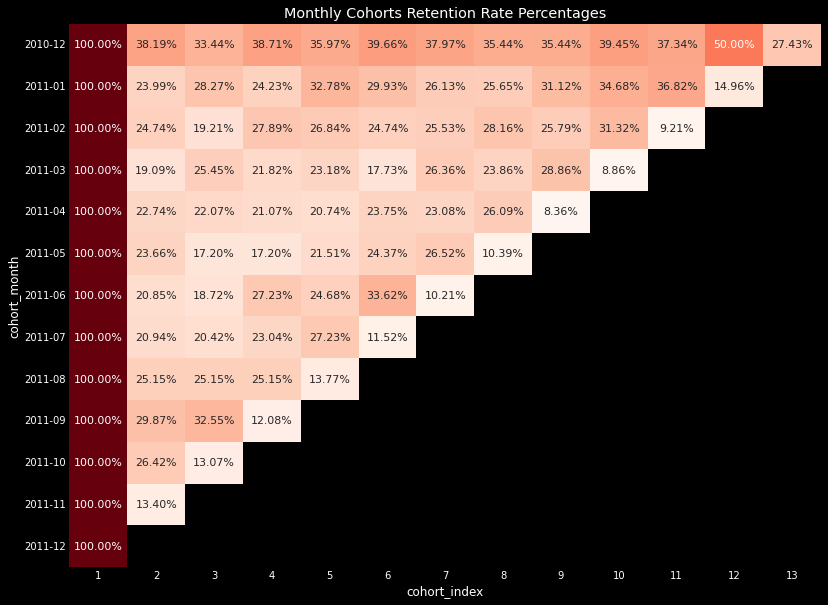

In [81]:
plt.rcParams["axes.facecolor"] = "black"
fig, ax = plt.subplots(figsize = (12, 10))
sns.heatmap(retention, cmap = "Reds", fmt = ".2%", annot_kws = {"fontsize": 11}, cbar = False, ax = ax, annot = True)
plt.title("Monthly Cohorts Retention Rate Percentages")
plt.yticks(rotation = 0)
plt.show()

There are typically two types of cohort analysis that can be done.
Product Lifetime: A product lifetime cohort is a group of customers who have purchased a product within a specified time frame, such as a month or a year. (analyze column wise in above figure)
User Lifetime: A user lifetime cohort is a group of users who have been active within a specified time frame, such as a month or a year. These groups are often used in cohort analysis, which is a method of tracking the behavior of a group of users over time. (analyze row wise in above figure )


In [69]:
customer_per_month = df_initial.groupby("cohort_month")["customer_id"].nunique().values
customers = customer_per_month.cumsum()
customers = customers[::-1]
customers

array([4372, 4331, 4010, 3658, 3360, 3193, 3002, 2767, 2488, 2189, 1749,
       1369,  948], dtype=int64)

In [70]:
customer_in_month = df_initial.groupby("cohort_index")["customer_id"].nunique()

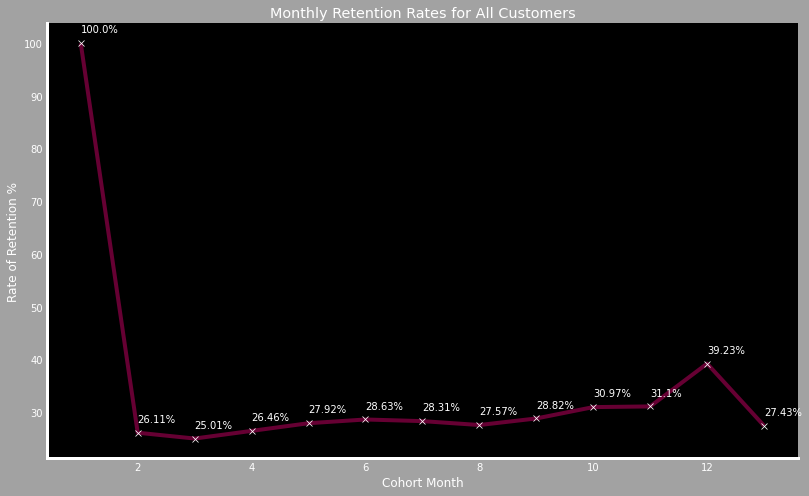

In [79]:
fig, ax = plt.subplots(figsize = (12, 8), facecolor = "#A2A2A2")
ax.grid(False)
x = customer_in_month.index
y = 100*(customer_in_month / customers)
sns.lineplot(x = x, y = y,  color = "#660033", marker = "x", markerfacecolor = "#660033", markeredgecolor = "#FFFFFF")
for x, y in zip(x, y):
    plt.text(x, y + 2, s = str(round(y, 2)) + "%")
plt.xlabel("Cohort Month")
plt.ylabel("Rate of Retention %")
plt.title("Monthly Retention Rates for All Customers")
plt.rcParams["axes.facecolor"] = "#000000"
sns.despine()
plt.show()

Above plot shows that the retention rate dramatically rises over the final months of the year, which is a result of the holiday season. 